<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/re-jig-for-book/sequences/P1C1_BehaviourAsPolicy/P1C1_Sequence3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **Sequence 1.1.3: Abstraction and Reasoning with Policies**

### Objective: In this sequence, we will reason about and compare different policies using the Gridworld environment-organism system from 1.1.1 and our understanding of the input --> compute --> output process as a policy from 1.1.2. In this sequence you will:
* Visualize and compare different policies.
* Incorporate a simple form of memory into a policy and expand our sense of what a policy as an abstraction of sensation --> neural computation --> behaviour can represent
* See how interaction in a shared environment can impact policy performance.

This will take us further along in answering the question 'What is a good policy?', specifically starting to appreciate how open ended and context dependent this question is.

Picture showing receptor/input, brain/compute, musceles/output embedded in the environment feedback loop, this time extended to allow the agent to have some internal state that it propigates into the next time step (some very limited version of 'memory'). (The following is a place holder for our actual image, same as last time, but it's close to the right thing, though not as close as in 1.1.2.)
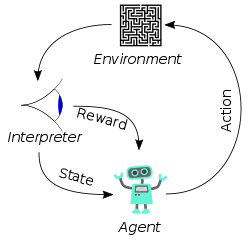

# Setup

Run the following cell to setup and install the various dependencies and helper functions for this sequence.

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

!pip install ipympl vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
import time
import logging
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from copy import copy
from scipy.spatial.distance import cdist
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict


# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C1_S3"




#################################################
# More plotting functions
#################################################


def plot_directions(fig, ax, loc_prob_dict, critter, deterministic=False,
                    name=None):
  """
  Plot vector field indicating critter direction probabilities.

  Args:
    fig, ax (matplotlib objects): Figure and axes objects for plotting.
    loc_prob_dict (dict): Dictionary with keys as (row, col) location tuples
      and values as lists of direction probabilities corresponding to the
      directions ['right', 'down', 'left', 'up'].
    critter (int): Identifier for which critter directions are associated with.
    deterministic (bool, optional): If True, the probabilities array is
      converted to 1-hot, and the arrows are plotted at the center of the cell
      and are larger. Defaults to False.
  """

  #looks like direction ignores inverted axis
  direction_vectors = {'right': (1, 0), 'down': (0, -1),
                       'left': (-1, 0), 'up': (0, 1)}
  # but offsets need to be aware of inverted
  direction_offsets = {'right': (0.1, 0), 'down': (0, 0.1),
                       'left': (-0.1, 0), 'up': (0, -0.1)}
  # Offsets for each critter type 1 and 2 to be used together, 0 by itself
  critter_offsets = {0: (0, 0), 1: (-0.05, -0.05), 2: (0.05, 0.05)}
  # same logic for colors
  critter_colors = {0: 'black', 1: 'red', 2: 'blue'}
  # Get the offset and color for this critter
  critter_offset = critter_offsets[critter]
  critter_color = critter_colors[critter]

  # Add legend only if critter is not 0
  custom_leg_handles = []
  if critter != 0:
    if name is None:
      name = f'Critter {critter}'
    legend_patch = mpatches.Patch(color=critter_color, label=name)
    # Add the legend for this critter
    custom_leg_handles.append(legend_patch)

  C, R, U, V, A = [], [], [], [], []

  for loc in loc_prob_dict.keys():
    row, col = loc
    probs = loc_prob_dict[loc]
    for dir_key, prob in probs.items():
      C.append(col + critter_offset[0] + direction_offsets[dir_key][0])
      R.append(row + critter_offset[1] + direction_offsets[dir_key][1])
      U.append(direction_vectors[dir_key][0])
      V.append(direction_vectors[dir_key][1])

      if deterministic:
        A.append(1 if prob == max(probs.values()) else 0)
      else:
        A.append(prob)

  linewidth = 1.5 if deterministic else 0.5
  scale = 15 if deterministic else 30

  ax.quiver(C, R, U, V, alpha=A, color=critter_color,
            scale=scale, linewidth=linewidth)
  return fig, ax, custom_leg_handles

def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for further use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PathCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if food is None:
    food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  rc_food_loc = np.array(rc_food_loc, dtype=int)
  #matrix indexing convention is is [row-vertical, col-horizontal]
  #plotting indexing convention is (x-horizontal,y-vertical), hence flip
  food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critters(fig, ax, critter_specs: List[Dict[str, object]]) -> List[Dict[str, object]]:
  """
  Plots multiple types of "critters" on a grid implied by the given
  fig, ax arguments.

  Args:
    fig, ax: matplotlib figure and axes objects.
    critter_specs: List of dictionaries with keys 'location', 'name', 'color',
    'marker', 'int_id', 'rc_critter_loc' and optionally 'handle' for each
    critter.

  Returns:
    Updated critter_specs with handles.
  """
  for spec in critter_specs:
    # Ensure required keys are present
    for key in ['marker', 'color', 'name', 'rc_loc']:
      if key not in spec:
        raise ValueError(f"Key '{key}' missing in critter spec.")
    handle_ = spec.get('handle')
    if handle_ is None:
      handle_ = ax.scatter([], [], s=250, marker=spec['marker'],
                           color=spec['color'], label=spec['name'])
    handle_.set_offsets(np.flip(spec['rc_loc']))
    spec.update({'handle': handle_})
  return critter_specs


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PathCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()




###########################################################
# new definition gridworld board to support multiple agents
###########################################################




class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  board state is represented by primarily by pieces, score, and rounds left
  pieces is a batch x n_rows x n_cols numpy array positive integers are critter
  locations 0's are empty space and -1's are food.

  For pieces first dim is batch, second dim row , third is col,
  so pieces[0][1][7] is the square in row 2, in column 8 of the first board in
  the batch of boards.

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  active_player keeps track of which players turn it is

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """


  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_critters=2, num_food=10,
               lifetime=30, rng = None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_critters = num_critters
    self.num_food = num_food
    self.lifetime = lifetime
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = (np.ones(self.batch_size) *
                        self.lifetime * self.num_critters)
    # each players move counts down the clock so making this a multiple of the
    # number of critters ensures every player gets an equal number of turns
    self.scores = np.zeros((self.batch_size, self.num_critters))
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols))
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+num_critter because we want critter and food locations
      int_loc, rc_idx, rc_plot = self.init_loc(
        self.n_rows, self.n_cols, self.num_food+self.num_critters)
      # critter random start locations
      for c_ in np.arange(self.num_critters):
        self.pieces[(ii, rc_idx[0][c_], rc_idx[1][c_])] = c_ + 1
      # food random start locations
      self.pieces[(ii, rc_idx[0][self.num_critters:],
                   rc_idx[1][self.num_critters:])] = -1
    self.active_player = 0
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'active_player': copy(self.active_player)}
    return state


  def set_state(self, board):
    """ board is dictionary giving game state a triple of np arrays
      pieces:        numpy array (batch_size x n_rows x n_cols),
      scores:        numpy array (batch_size x num_critters)
      rounds_left:   numpy array (batch_size)
      active_player: int
    """
    self.pieces = board['pieces'].copy()
    self.scores = board['scores'].copy()
    self.rounds_left = board['rounds_left'].copy()
    self.active_player = copy(board['active_player'])


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'active_player': copy(self.active_player)}
    return state


  def __getitem__(self, index):
    return self.pieces[index]


  def execute_moves(self, moves, critter):
    """
    Updates the state of the board given the moves made.

    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord.

    Notes:
      Assumes that there is exactly one valid move for each board in the
      batch of boards for the critter type given. i.e. it does't check for
      bounce/reflection on edges or with other critters, or for multiple move
      made on the same board. It only checks for eating food and adds new food
      when appropriate. Invalid moves could lead to illegal teleporting
      behavior, critter duplication, or index out of range errors.

      Currently just prints a message if critter making the move is not the
      active player, could enforce this more strictly if needed.
    """
    if critter-1 != self.active_player:
      # note critter is [1 to num_critter] inclusive so that it can be used
      # directly in where statements on pieces but self.active_player is
      # [0 to numcritter-1] inclusive so that it can be used directly in
      # indexing player lists
      raise ValueError("Warning! The critter moving is not the expected active player")
    #critters leave their spots
    self.pieces[self.pieces==critter] = 0
    #which critters have food in their new spots
    eats_food = self.pieces[moves] == -1
    # some critters eat and their scores go up
    # note critter is +int so need to -1 for indexing
    self.scores[:,critter-1] = self.scores[:,critter-1] + eats_food

    num_empty_after_eat = (self.n_rows*self.n_cols - self.num_food -
                           self.num_critters + 1) # +1 for the food just eaten
    # which boards in the batch had eating happen
    g_eating = np.where(eats_food)[0]
    # put critters in new positions
    self.pieces[moves] = critter
    if np.any(eats_food):
      # add random food to replace what is eaten
      possible_new_locs = np.where(np.logical_and(
          self.pieces == 0, #the spot is empty
          eats_food.reshape(self.batch_size, 1, 1))) #food eaten on that board
      food_sample_ = self.rng.choice(num_empty_after_eat,
                                     size=np.sum(eats_food))
      food_sample = food_sample_ + np.arange(len(g_eating))*num_empty_after_eat
      assert np.all(self.pieces[(possible_new_locs[0][food_sample],
                                 possible_new_locs[1][food_sample],
                                 possible_new_locs[2][food_sample])] == 0)
      #put new food on the board
      self.pieces[(possible_new_locs[0][food_sample],
                   possible_new_locs[1][food_sample],
                   possible_new_locs[2][food_sample])] = -1
    self.rounds_left = self.rounds_left - 1
    if not np.all(self.pieces.sum(axis=(1,2)) ==
                  ((self.num_food * -1) + np.sum(np.arange(self.num_critters)+1))):
      print(self.pieces.sum(axis=(1,2)))
      print(((self.num_food * -1) + np.sum(np.arange(self.num_critters)+1)))
    assert np.all(self.pieces.sum(axis=(1,2)) ==
                  ((self.num_food * -1) + np.sum(np.arange(self.num_critters)+1)))
    # next player's turn
    self.active_player = (self.active_player + 1) % (self.num_critters)


  def get_legal_moves(self, critter):
    """
    Identifies all legal moves for the critter, taking into account
    bouncing/reflection at edges,

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """
    # can only move one cell down, up, right, and left from current location
    critter_locs = np.array(np.where(self.pieces == critter))
    legal_offsets = np.stack([
      critter_locs + np.array([np.array([0,  1, 0])]*self.batch_size).T,
      critter_locs + np.array([np.array([0, -1, 0])]*self.batch_size).T,
      critter_locs + np.array([np.array([0, 0,  1])]*self.batch_size).T,
      critter_locs + np.array([np.array([0, 0, -1])]*self.batch_size).T])
    legal_offsets = np.vstack(np.transpose(legal_offsets, (0, 2, 1)))
    legal_offsets = set([tuple(m_) for m_ in legal_offsets])
    # must land on the board and not on another critter
    legal_destinations = np.where(self.pieces <= 0)
    legal_destinations = set([(g, r, c) for
                              g, r, c in zip(*legal_destinations)])
    # legal moves satisfy both these conditions
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_perceptions(self, radius, critter):
    """
    Generates a vector representation of the critter perceptions, oriented
    around the critter.

    Args:
      radius: int, how many grid squared the critter can see around it
        using L1  (Manhattan/cityblock) distance

    Returns:
      A batch_size x 2*radius*(radius+1) + 1, giving the values
      of the percept reading left to right, top to bottom over the board,
      for each board in the batch
    """
    # define the L1 ball mask
    diameter = radius*2+1
    mask = np.zeros((diameter, diameter), dtype=bool)
    mask_coords = np.array([(i-radius, j-radius)
      for i in range(diameter)
        for j in range(diameter)])
    mask_distances = cdist(mask_coords, [[0, 0]],
                           'cityblock').reshape(mask.shape)
    mask[mask_distances <= radius] = True
    mask[radius,radius] = False  # exclude the center

    # pad the array
    padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
     (radius, radius)), constant_values=-2)

    # get locations of critters
    critter_locs = np.argwhere(padded_arr == critter)

    percepts = []
    for critter_loc in critter_locs:
      b, r, c = critter_loc
      surrounding = padded_arr[b, r-radius:r+radius+1, c-radius:c+radius+1]
      percept = surrounding[mask]
      percepts.append(percept)
    return(np.array(percepts))




################################################################
# refactor Monte Carlo for boards that support multiple critters
################################################################




class MonteCarlo():
  """
  Implementation of Monte Carlo Algorithm
  """


  def __init__(self, game, nnet, default_depth=5, random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth
    self.rng = np.random.default_rng(seed=random_seed)


  def pis_vs_from_board(self, board, critter):
    #helper function, to put board in canonical form that nn was trained on
    batch_size, n_rows, n_cols = board['pieces'].shape
    co_pieces = board['pieces'].copy()
    this_critter_locs = np.where(co_pieces == critter)
    all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    co_pieces[this_critter_locs] = 1
    scalar_rounds_left = board['rounds_left'][0]
    co_rounds_left = scalar_rounds_left // self.game.num_critters
    if critter-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
       co_rounds_left = co_rounds_left + 1
    co_rounds_left = np.array([co_rounds_left]*batch_size)
    pis, vs = self.nnet.predict(co_pieces,
                                board['scores'][:,critter-1],
                                co_rounds_left)
    return pis, vs


  def simulate(self, board, actions, action_indexes, critter=1, depth=None):
    """
    Helper function to simulate one Monte Carlo rollout

    Args:
      board: triple (batch_size x x_size x y_size np.array of board position,
                     scalar of current score,
                     scalar of rounds left
      actions: batch size list/array of integer indexes for moves on each board
      these are assumed to be legal, no check for validity of moves
    Returns:
      temp_v:
        Terminal State
    """
    batch_size, x_size, y_size = board['pieces'].shape
    next_board = self.game.get_next_state(board, critter,
                                          actions, action_indexes)
    # in this version of the mc player, the existence of other players is
    # ignored, in another version of mc other players moves might be simulated
    next_board['active_player'] = critter-1

    if depth is None:
      depth = self.default_depth
    # potentially expand the game tree here,
    # but just do straight rollouts after this
    # doesn't expand to deal with all random food generation possibilities
    # just expands based on the actions given
    expand_bs, _, _ = next_board['pieces'].shape

    for i in range(depth):  # maxDepth
      if next_board['rounds_left'][0] <= 0:
        # check that game isn't over
        # assumes all boards have the same rounds left
        # no rounds left return scores as true values
        terminal_vs = next_board['scores'][:,critter-1].copy()
        return terminal_vs
      else:
        #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'], next_board['rounds_left'])
        pis, vs = self.pis_vs_from_board(next_board, critter)
        valids = self.game.get_valid_actions(next_board, critter)
        masked_pis = pis * valids
        sum_pis = np.sum(masked_pis, axis=1)
        probs = np.array(
            [masked_pi / masked_pi.sum() if masked_pi.sum() > 0
             else valid / valid.sum()
             for valid, masked_pi in zip(valids, masked_pis)])
        samp = self.rng.uniform(size = expand_bs).reshape((expand_bs,1))
        sampled_actions = np.argmax(probs.cumsum(axis=1) > samp, axis=1)
      next_board = self.game.get_next_state(next_board, critter,
                                            sampled_actions)
      # in this version of the mc player, existence of other players is ignored
      # in another better version other players moves might be simulated, either
      # as copies of self, or as distinct environmental dynamics
      next_board['active_player'] = critter-1


    pis, vs = self.pis_vs_from_board(next_board, critter)
    #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'],
    #                            next_board['rounds_left'])
    #print(vs.shape)
    return vs




###########################################################################
# make a separate player zoo
###########################################################################




class RandomValidPlayer():
  """
  Instantiate random player for GridWorld
  """


  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, x_size, y_size = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index)
    action_size = self.game.get_action_size()

    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)

    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    return np.array(a), a_1hots, probs




class RandomDirectionPlayer():
  """
  Instantiate random player for GridWorld
  """

  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."

  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function assigns a uniform probability to going up down left or right
    independent of whether it is at an edge or corner or not. Then because of
    bouncing off edges it will have a higher probability of moving away from
    edges as opposed to along them than the random valid move player.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    action_probs = {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}

    critter_oriented_moves = self.game.rng.choice(list(action_probs.keys()),
                                                  size=(batch_size))
    direction_probs = [action_probs] * batch_size
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm

  Note: Has dependencies in the gw_NN_RL.py util, namely a policy/value
  network and the Monte Carlo class.
  """

  def __init__(self, game, nnet,
               critter_index=1,
               default_depth=1,
               default_rollouts=1,
               default_K=4,
               default_temp=1.0,
               random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.nnet = nnet
    self.default_depth = default_depth
    self.default_rollouts = default_rollouts
    self.mc = MonteCarlo(self.game, self.nnet, self.default_depth)
    self.default_K = default_K
    self.default_temp = default_temp
    self.rng = np.random.default_rng(seed=random_seed)


  def play(self, board,
           num_rollouts=None,
           rollout_depth=None,
           K=None,
           softmax_temp=None):
    """
    Simulates a batch Monte Carlo based plays on the given board state.

    Computes the probability of each valid move being played using a softmax
    activation on the Monte Carlo based value (Q) of each action then selects a
    move randomly for each game in the batch based on those probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if num_rollouts is None:
      num_rollouts = self.default_rollouts
    if rollout_depth is None:
      rollout_depth = self.default_depth
    if K is None:
      K = self.default_K
    if softmax_temp is None:
      softmax_temp = self.default_temp

    # figure out top k actions according to normalize action probability
    # given by our policy network prediction
    #co_pieces = board['pieces'].copy()
    #this_critter_locs = np.where(co_pieces == self.critter_index+1)
    #all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    #co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    #co_pieces[this_critter_locs] = 1
    #scalar_rounds_left = board['rounds_left'][0]
    #co_rounds_left = scalar_rounds_left // self.game.num_critters
    #if self.critter_index-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
    #   co_rounds_left = co_rounds_left + 1
    #co_rounds_left = np.array([co_rounds_left]*batch_size)
    #pis, vs = self.nnet.predict(co_pieces,
    #                            board['scores'][:,self.critter_index-1],
    #                            co_rounds_left)
    pis, vs = self.mc.pis_vs_from_board(board, self.critter_index)
    valids = self.game.get_valid_actions(board, self.critter_index)
    masked_pis = pis * valids  # Masking invalid moves
    sum_pis = np.sum(masked_pis, axis=1)
    num_valid_actions = np.sum(valids, axis=1)
    effective_topk = np.array(np.minimum(num_valid_actions, K), dtype= int)
    probs = np.array([masked_pi / masked_pi.sum() if masked_pi.sum() > 0
                      else valid / valid.sum()
                      for valid, masked_pi in zip(valids, masked_pis)])
    partioned = np.argpartition(probs,-effective_topk)
    topk_actions = [partioned[g,-(ii+1)]
                      for g in range(batch_size)
                        for ii in range(effective_topk[g])]
    topk_actions_index = [ii
                            for ii, etk in enumerate(effective_topk)
                              for _ in range(etk)]
    values = np.zeros(len(topk_actions))
    # Do some rollouts
    for _ in range(num_rollouts):
      values = values + self.mc.simulate(board, topk_actions,
                                         topk_actions_index,
                                         critter=self.critter_index,
                                         depth=rollout_depth)
    values = values / num_rollouts

    value_expand = np.zeros((batch_size, n_rows*n_cols))
    value_expand[(topk_actions_index, topk_actions)] = values
    value_expand_shift = value_expand - np.max(value_expand, axis=1, keepdims=True)
    value_expand_scale = value_expand_shift/softmax_temp
    v_probs = np.exp(value_expand_scale) / np.sum(
        np.exp(value_expand_scale), axis=1, keepdims=True)
    v_probs = v_probs * valids
    v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
    samp = self.rng.uniform(size = batch_size).reshape((batch_size,1))
    sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
    a_1Hots = np.zeros((batch_size, n_rows*n_cols))
    a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class SimpleRulePlayer():
  """
  A Player based on the following simple policy:
  If there is any food immediately nearby move towards it,
  otherwise it move randomly.
  """

  def __init__(self, game, fov_radius=2, critter_index=1):
    """

    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.fov_radius = fov_radius


  def simple_action_from_percept(self, percept):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D array (len 12 if fov_radius = 2)representing the perception
        of the organism. Indices correspond to spaces around the organism. The
        values in the array can be -2 (out-of-bounds), 0 (empty space), or
        -1 (food).

    Returns:
      action: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
    """
    # a human interpretable overview of the percept structure
    percept_struct = [
      'far up', 'left up', 'near up', 'right up',
      'far left', 'near left', 'near right', 'far right',
      'left down', 'near down', 'right down', 'far down']
    # Defines directions corresponding to different perception indices
    direction_struct = [
      'None', 'None', 'up', 'None',
      'None', 'left', 'right', 'None',
      'None', 'down', 'None', 'None']
    # these are what count as nearby in the percept
    nearby_directions = ['near up', 'near left', 'near right', 'near down']
    # Get the corresponding indices in the percept array
    nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
    # Identify the directions where food is located
    food_indices = [index for index in nearby_indices if percept[index] == -1]
    food_directions = [direction_struct[index] for index in food_indices]

    action_probs = {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 0.0}
    if len(food_directions) > 0:  # If there is any food nearby
      # If there is any food nearby randomly choose a direction with food
      action = self.game.rng.choice(food_directions)  # Move towards a random one
      for direction in food_directions:
        action_probs[direction] = 1.0 /len(food_directions)
    else:
      # If there is no food nearby, move randomly
      action = self.game.rng.choice(['up', 'down', 'left', 'right'])
      for direction in ['up', 'down', 'left', 'right']:
        action_probs[direction] = 0.25

    return action, action_probs


  def play(self, board):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)

    critter_oriented_moves = []
    direction_probs = []
    for g in range(batch_size):
      action, action_probs = self.simple_action_from_percept(perceptions[g])
      critter_oriented_moves.append(action)
      direction_probs.append(action_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                direction_probs,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class PerceptParamPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=2, critter_index=1):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter perceives, weights is
        expecting fov_radius = 2
    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    if weights is None:
      self.W = np.array(
      [[1., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1.],
       [0., 1., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 1., 0.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def param_action_from_percept(self, percept, valid_directions, W,
                                softmax_temp=None):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D len 12 array representing the perception of the organism.
        Indices correspond to spaces around the organism. The values in the
        array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      direction: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
      direction_probs: dictionary with probabilities of taking each action.
    """
    if len(valid_directions) == 0:
      # if there is no where legit to move, stay put
      return 'still', {direction: 0 for direction in output_struct}

    if softmax_temp is None:
      # very low temp, basically deterministic for this range of values
      softmax_temp = self.default_softmax_temp
    # a human interpretable overview of the percept structure
    percept_struct = [
      'far up', 'left up', 'near up', 'right up',
      'far left', 'near left', 'near right', 'far right',
      'left down', 'near down', 'right down', 'far down']
    # a human interpretable overview of the out structure
    output_struct = ['up', 'down', 'left', 'right']
    # boolean representation of percept, no edges, just 1's where food is,
    # zero otherwise, also means other organisms are invisible
    x = np.asarray(percept == -1, int)
    output_activations = W @ x

    # softmax shift by max, scale by temp
    shift_scale_ex = np.exp((output_activations -
                             np.max(output_activations))/softmax_temp)
    # set invalid direction activations to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in valid_directions]
    sm = shift_scale_ex / shift_scale_ex.sum() #normalized
    # set invalid direction probabilities to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in invalid_directions]
    sm[invalid_indices] = 0
    probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp issues
    direction = self.game.rng.choice(output_struct, p=probs_sm)
    direction_probs = {direction: prob
                        for direction, prob in zip(output_struct, probs_sm)}
    return direction, direction_probs


  def play(self, board, temp=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)
    critter_oriented_moves = []
    direction_probs = []

    # Get valid actions for each game in the batch
    valid_directions = self.game.get_valid_directions(board, self.critter_index)
    for g in range(batch_size):
      direction, batch_direction_probs = self.param_action_from_percept(
        perceptions[g], valid_directions[g], self.W, softmax_temp=temp)
      critter_oriented_moves.append(direction)
      direction_probs.append(batch_direction_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################




class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=7, n_cols=7,
               num_critters=2, num_food=10,
               lifetime=30, rng=None):
    """
    Initializes an instance of the class with the specified parameters.

    Args:
      batch_size (int, optional): Number of instances in a batch. Default is 1.
      n_rows (int, optional): Number of rows in the grid. Default is 7.
      n_cols (int, optional): Number of columns in the grid. Default is 7.
      num_critters (int, optional): Number of different agents running around
        on each board in the batch. Default is 2.
      num_food (int, optional): Number of food items. Default is 10.
      lifetime (int, optional): Time before critter's life ends, in terms of
        time steps. Default is 30.
      rng (numpy random number generator, optional): Random number generator
        for reproducibility. If None, uses default RNG with a preset seed.
    """

    # Check for positive integer inputs
    assert all(isinstance(i, int) and i >= 0
               for i in [batch_size, n_rows, n_cols, num_critters, num_food,
                         lifetime]), "All inputs must be non-negative integers."
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_critters = num_critters
    # Check for num_food exceeding maximum possible value
    max_food = n_rows * n_cols - num_critters
    if num_food > max_food:
      print(f'num_food is too large, setting it to maximum possible value: {max_food}')
      num_food = max_food
    self.num_food = num_food
    self.lifetime = lifetime
    # Set up random number generator
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    return b.get_init_board_state()


  def get_board_size(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,r,c coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 0-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to r,c indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g=0):
    """ A bytestring representation board g's state in the batch of boards"""
    return (board['pieces'][g].tobytes() + board['scores'][g].tobytes() +
            board['rounds_left'][g].tobytes())


  def get_square_symbol(self, piece):
    """ Translate integer piece value to symbol for display"""
    if piece == -1:
      return "X"
    elif piece == 0:
      return "-"
    elif piece >= 1:
      return "0"
    else:
      return "???????????????????????????"


  def string_rep_readable(self, board, g=0):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.get_square_symbol(square)
                        for row in board['pieces'][g]
                          for square in row])
    board_s = board_s + '_' + str(board['scores'][g])
    board_s = board_s + '_' + str(board['rounds_left'][g])
    return board_s


  def get_scores(self, board):
    return board['scores'].copy()


  def get_rounds_left(self, board):
    return board['rounds_left'].copy()


  def display(self, board, g=0):
    """Displays the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for c_ in range(self.n_cols):
      print(c_, "|", end="")    # Print the row
      for r_ in range(self.n_rows):
        piece = board['pieces'][g,c_,r_]    # Get the piece to print
        #print(piece)
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board['rounds_left'][g]))
    print("Score: " + str(board['scores'][g]))


  def get_critter_rc(self, board, g, critter_index):
    return np.squeeze(np.array(np.where(board['pieces'][g]==critter_index)))


  def plot_moves(self, board, player0, g=0, player1=None,
                 fig=None, ax=None, p0_name='Player 0', p1_name='Player 1',
                 figsize=(6,5), critter_name='Critter', title=None,
                 deterministic=False):
    """
    Uses plotting functions to make picture of the current board state, and what
    a critter would do at each non-food location in the current board state
    """
    def make_prob_dict(critter_locs, play):
      offset_dict = {(0, 1): 'right',
                     (0,-1): 'left',
                     ( 1, 0): 'down',
                     (-1, 0): 'up'}
      index_probs = play[2].copy()
      loc_prob_dict = {}
      # for each non food locations
      for g, loc_ in enumerate(critter_locs):
        # this is the location as an r, c tuple
        rc_tup = tuple((loc_[1], loc_[2]))
        # the relevant probabilities
        raw_probs = index_probs[g]
        probs = raw_probs[raw_probs > 0]
        indexes = np.argwhere(raw_probs > 0)
        # turn the probability indexes into r, c coords
        rows = np.floor_divide(indexes, gwg.n_cols)
        cols = np.remainder(indexes, gwg.n_cols)
        moves = np.squeeze(np.array([z for z in zip(rows, cols)]), axis=2)
        #compute the offsets and turn them to strings
        offsets = moves - loc_[1:]
        str_offsets = np.array(list(map(offset_dict.get, map(tuple, offsets))))
        # update the loc_prob_dict for plotting
        prob_dict = dict(zip(str_offsets, probs))
        loc_prob_dict.update({rc_tup: prob_dict})
      return loc_prob_dict

    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    rc_food_index = np.array(np.where(board['pieces'][g] == -1))
    rc_food_plotting = np.array(rc_food_index).T
    food = plot_food(fig, ax, rc_food_plotting)

    expanded_board = self.critter_everywhere_state_expansion(
      board, player0.critter_index, to_expand=g)
    critter_locs = np.argwhere(expanded_board['pieces']==player0.critter_index)
    #play the expanded state
    p0_play = player0.play(expanded_board)
    #get the prob dict
    p0_loc_prob_dict = make_prob_dict(critter_locs, p0_play)
    # same for player1 if there is one
    if player1 is not None:
      p1_play = player1.play(expanded_board)
      p1_loc_prob_dict = make_prob_dict(critter_locs, p1_play)

    existing_handels, _ = ax.get_legend_handles_labels()
    if player1 is None:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=0, deterministic=deterministic)
      leg_handles = existing_handels
    else:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=1, deterministic=deterministic, name=p0_name)
      fig, ax, leg_handles_1 = plot_directions(fig, ax, p1_loc_prob_dict,
        critter=2, deterministic=deterministic, name=p1_name)
      leg_handles = existing_handels + leg_handles_0 + leg_handles_1

    fig.legend(handles=leg_handles, loc="outside right upper")
    fig.canvas.draw()
    return fig, ax


  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war feild_of_view
                 radius=2, figsize=(6,5), title=None,
                 name='Critter'):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_critters):
        critter_name = name if self.num_critters == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_critters, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(np.where(board['pieces'][g] == spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] == -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)

    #plot field of view if doing that
    if has_fov:
      # will need to think about how to do this for multiple
      # critters, currently just use rc of first critter in the spec list
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[0]['rc_loc'], n_rows, n_cols,
                       radius, has_fov)
      else:
        fov = plot_fov(fig, ax, critter_specs[0]['rc_loc'], n_rows, n_cols,
                       radius, has_fov, fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_valid_actions(self, board, critter):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=batch_size, n_rows=n_rows,
                       n_cols=n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(critter)
    valids = np.zeros((batch_size, n_rows * n_cols))
    for g, r, c in legal_moves:
      valids[g, r * n_cols + c] = 1
    return valids


  def display_moves(self, board, critter=1, g=0):
    """Displays possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    A=np.reshape(self.get_valid_actions(board, critter)[g],
                 (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for col in range(self.n_cols):
      print(col, end=" ")
    print("")
    print("-----------------------")
    for col in range(self.n_cols):
      print(col, "|", end="")    # Print the row
      for row in range(self.n_rows):
        piece = A[col][row]    # Get the piece to print
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")


  def get_perceptions(self, board, radius, critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=batch_size, n_rows=n_rows,
                       n_cols=n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    return(b.get_perceptions(radius, critter))


  def get_next_state(self, board, critter, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if board['rounds_left'][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      moves = self.actions_to_moves(actions)
      b = GridworldBoard(batch_size=len(actions), n_rows=n_rows,
                         n_cols=n_cols, num_critters=self.num_critters,
                         num_food=self.num_food, lifetime=self.lifetime,
                         rng=self.rng)
      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        new_pieces = np.array([board['pieces'][ai].copy() for ai in a_indx])
        new_scores = np.array([board['scores'][ai].copy() for ai in a_indx])
        new_rounds_left = np.array([board['rounds_left'][ai].copy() for ai in a_indx])
        new_active_player = copy(board['active_player'])
        new_state = {'pieces': new_pieces,
                     'scores': new_scores,
                     'rounds_left': new_rounds_left,
                     'active_player': new_active_player}
        b.set_state(new_state)
      b.execute_moves(moves, critter)
      return b.get_state()


  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves


  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions


  def critter_oriented_get_next_state(self, board, critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=batch_size, n_rows=n_rows,
                       n_cols=n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, critter)
    b.execute_moves(moves, critter)
    return(b.get_state())


  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right'
      critter: integer index for the critter we want moves for

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = np.where(board['pieces'] == critter)
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves


  def direction_probs_to_flat_probs(self, board, direction_probs):
    """
    Converts direction probabilities in reference to the critter's location into
    probability arrays on the flattened board.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      direction_probs: batch length list of dictionaries with keys
        ['up', 'down', 'left', 'right'] and corresponding probabilities.

    Returns:
      probs_arrays: list of arrays, where each array is of length n_rows*n_cols
                    and represents the flattened probability distribution for
                    board in the batch.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {
        'up': (0, -1, 0),
        'down': (0, 1, 0),
        'left': (0, 0, -1),
        'right': (0, 0, 1)
    }
    critter_locs = np.where(board['pieces'] == 1)
    probs_arrays = []
    for batch_index in range(batch_size):
      prob_array = np.zeros(n_rows * n_cols)
      for direction, prob in direction_probs[batch_index].items():
          offset = np.array(offset_dict[direction])
          new_loc = np.array(critter_locs)[:, batch_index] + offset
          # Check bounces at boundaries
          new_loc[1] = np.where(new_loc[1] >= n_rows, n_rows-2, new_loc[1])
          new_loc[2] = np.where(new_loc[2] >= n_cols, n_cols-2, new_loc[2])
          new_loc[1] = np.where(new_loc[1] < 0, 1, new_loc[1])
          new_loc[2] = np.where(new_loc[2] < 0, 1, new_loc[2])
          # Convert 2D location to flattened index
          flattened_index = new_loc[1] * n_cols + new_loc[2]
          prob_array[flattened_index] += prob
      probs_arrays.append(prob_array)
    return probs_arrays


  def action_to_critter_direction(self, board, critter, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right'
    """
    offset_dict = {(0, 0, 1): 'right',
                   (0, 0,-1): 'left',
                   (0, 1, 0): 'down',
                   (0,-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    critter_locs = np.where(board['pieces'] == critter)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    # need to reverse this from above, moves is equiv to new_locs
    # new_locs = np.array(critter_locs) + offsets_array
    offsets_array = np.array(moves) - np.array(critter_locs)
    offsets = [offset_dict[tuple(o_)] for o_ in offsets_array.T]
    return offsets


  def get_valid_directions(self, board, critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    valid_directions = []
    for g, batch_valids in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valids==1)[0]
      critter_loc = np.squeeze(np.array(np.where(board['pieces'][g] == critter)))
      batch_valid_directions = []
      for a in valid_int_indices:
        move = np.array([np.floor_divide(a, n_cols), np.remainder(a, n_cols)])
        offset = move - critter_loc
        batch_valid_directions.append(offset_dict[tuple(offset)])
      valid_directions.append(batch_valid_directions)
    return valid_directions

  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended
    Returns a batch size np.array of -1 if not ended, and scores for each game
    in the batch if it is ended, note only returns scores if all games in the
    batch have ended
    """
    rounds_left = board['rounds_left']
    scores = board['scores']
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores


  def critter_everywhere_state_expansion(self, board_state,
                                         critter=1, to_expand=0):
    """
    Expand a given board state by placing a critter at each non-food location.

    The function takes a game state and returns an expanded version of it. For
    each board in the state, it creates a new version of the board for every
    non-food location, placing a critter at that location. The scores and
    remaining rounds are copied for each new board. The result is a new game state
    with a larger number of boards, each representing a possible configuration
    with a critter at a different location.

    Args:
      board_state (dict): A dictionary containing the current game state.
      It should have the following keys:
        - 'pieces': a 3D numpy array (batch x n_col x n_row) representing the game
          board. -1 -> food, 0 -> empty cell, and 1 -> critter.
        - 'scores': 1D numpy array of the score for each board in the batch.
        - 'rounds_left': a 1D numpy array of the rounds left for
          each board in the batch.
      critter: integer index to place on the expanded board state
      to_expand (list (int)): list of batch indices to have state expanded

    Returns:
      dict: A dictionary containing the expanded game state with the same keys
        as the input. The number of boards will be larger than the input state.
    """
    pieces = board_state['pieces'].copy()
    scores = board_state['scores'].copy()
    rounds_left = board_state['rounds_left'].copy()
    active_player = copy(board_state['active_player'])
    # Determine non-food locations
    non_food_locs = np.argwhere(pieces[to_expand] != -1)
    #scrub all existing critter locations,
    # maybe later only scrub specific critter type
    pieces[pieces >= 1] = 0
    # lists to store expanded states
    expanded_pieces = []
    expanded_scores = []
    expanded_rounds_left = []
    # Iterate over each non-food location
    for i in range(non_food_locs.shape[0]):
      # Create a copy of the board
      expanded_board = np.copy(pieces[to_expand])
      # Place the critter at the non-food location
      # later consider only placing at non-food,
      # non-other critter locs
      expanded_board[tuple(non_food_locs[i])] = critter
      # Add the expanded board to the list along score and rounds_left
      expanded_pieces.append(expanded_board)
      expanded_scores.append(scores[to_expand])
      expanded_rounds_left.append(rounds_left[to_expand])
    # Convert to arrays and create expanded board state
    expanded_state = {'pieces': np.stack(expanded_pieces),
                      'scores': np.array(expanded_scores),
                      'rounds_left': np.array(expanded_rounds_left),
                      'active_player': active_player}
    return expanded_state




########################################
# widgets refactor for multi-critter
#########################################
# Interactive Gridworld Game Widgets




class InteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, gridworld_game, init_board=None, has_fov=False,
               radius=2, collect_fov_data=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the gridworld_game.num_critters
        attribute. Order should align with critter_name.

      Note: fov is going to look pretty janky with more than one player, maybe
      we get fov to only turn on for the 'active' player?
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.has_fov = has_fov
    self.radius = radius
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.gwg.num_critters):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] # implicit check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
      min_width='25.0em', min_height='18.8em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if self.collect_fov_data and self.any_human_players:
      self.legend_type = None # don't keep regenerating the legend
      # do legend separately if showing observations and no human player
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          legend_type='separate', figsize=self.figsize, has_fov=self.has_fov,
          radius=self.radius)
    elif len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, figsize=self.figsize)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.gwg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                radius=self.radius, figsize=self.figsize)
    # lump buttons together
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])

      if len(self.players) == 1:
        self.output_and_score = widgets.HBox([self.scoreboard, self.output])
        self.no_table_final_display = widgets.VBox([self.board_and_buttons,
                                                  self.output_and_score])
        if self.collect_fov_data == True:
          # a single human player collecting data
          self.final_display = widgets.HBox([self.no_table_final_display,
                                           self.fov_eat_table_display])
        else: # self.collect_fov_data == False:
          # a single human player not collecting data
          self.final_display = self.no_table_final_display
      else:
        # more than one player, one of them human
        self.V_board_outbput = widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        self.final_display = widgets.HBox([self.V_board_outbput,
                                             self.V_scoreboard_start_legend])
    else: # player is some kind of ai
      if self.collect_fov_data == True:
        # an ai player with recording
        # in this case legend is separate
        self.V_score_start_output_legend = widgets.VBox([self.scoreboard,
          self.start_button,  self.output, self.b_fig_legend.canvas])
        self.V_board_table = widgets.VBox([self.b_fig.canvas,
                                           self.fov_eat_table_display])
        self.final_display = widgets.HBox([self.V_board_table,
                                           self.V_score_start_output_legend])
      else:
        if len(self.players) == 1:
          # an ai player without recording
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = widgets.VBox([
            self.b_fig.canvas, self.H_score_output_start])
        else:
          # more than one ai player
          self.V_board_outbput = widgets.VBox([self.b_fig.canvas, self.output])
          self.V_scoreboard_start_legend = widgets.VBox([
              self.scoreboard, self.start_button, self.b_fig_legend.canvas])
          self.final_display = widgets.HBox([self.V_board_outbput,
                                             self.V_scoreboard_start_legend])

    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:'] + ['--'] * self.gwg.num_critters,
               ['Last Score:'] + ['--'] * self.gwg.num_critters,
               ['Average Score:'] + ['--'] * self.gwg.num_critters,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    # index is 0 through num_critter-1, critter value in pieces is
    # index + 1
    active_player_index = old_board['active_player']
    old_scores = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]

    #print(self.players[active_player_index])
    #print(active_player_index)
    #if not self.players[active_player_index] == 'human':
    #  print(self.players[active_player_index].critter_index)
    #else:
    #  print('human has no critter_index attribute')

    if (isinstance(self.players[active_player_index], str) and
        'human' in self.players[active_player_index]):
      direction = which_button
    else:
      a_player, _, _ = self.players[active_player_index].play(old_board)
      a_player = self.gwg.action_to_critter_direction(old_board,
                                                      active_player_index+1,
                                                      a_player)
      # but we only want to apply their move to the appropriate board
      direction = a_player[0]

    self.board_state = self.gwg.critter_oriented_get_next_state(
          self.board_state, active_player_index+1, [direction])
    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = np.floor(self.gwg.lifetime -
                         rounds_left / self.gwg.num_critters)
    if new_scores[active_player_index] > old_scores[active_player_index]:
      #eating happened
      eating_string = "They ate the food there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0,
                                       active_player_index+1)
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             radius=self.radius, legend_type=self.legend_type)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter (tried) to move " + direction +
              " and is now at ({}, {}).".format(row,col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
            rounds_left, new_scores[active_player_index],
            new_scores[active_player_index] / num_moves))
      else: # more than one players
        print("Critter {} (tried) to move ".format(active_player_index+1) +
              direction +
              " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}".format(
            rounds_left, new_scores))
    if rounds_left == 0:
      self.final_scores.append(new_scores)
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_crit_specs, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius,
                               legend_type=self.legend_type)
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.players) == 1:
          if len(self.final_scores) > 0:
            table = [
              ['High Score:', str(np.max(np.array(self.final_scores)))],
              ['Last Score:', str(self.final_scores[-1])],
              ['Average Score',
              '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
          else:
            table = [['High Score:', '--'],
                     ['Last Score:', '--'],
                     ['Average Score:', '--']]
          print(tabulate(table))
        else: # len(self.players) > 1
          headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
          if len(self.final_scores) > 0:
            table = []
            # Assuming the batch size is 1 for now
            current_scores = self.final_scores[-1]
            max_scores = np.max(np.array(self.final_scores), axis=0)
            average_scores = np.mean(np.array(self.final_scores), axis=0)
            table.append(['High Scores:'] +
              [str(score) for score in max_scores])
            table.append(['Last Scores:'] +
              [str(score) for score in current_scores])
            table.append(['Average Scores:'] +
              ['{:.2f}'.format(score) for score in average_scores])
          else:
            table = [
              ['High Score:'] + ['--'] * self.gwg.num_critters,
              ['Last Score:'] + ['--'] * self.gwg.num_critters,
              ['Average Score:'] + ['--'] * self.gwg.num_critters,]
          print(tabulate(table, headers=headers))

    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

  def human_ai_player_loop(self, direction):
    self.disable_direction_buttons()
    for player in self.players:
      if player == 'human':
        self.button_output_update(direction)
      else:
        self.button_output_update('tbd')
    self.enable_direction_buttons()

  def on_up_button_clicked(self, *args):
    self.human_ai_player_loop('up')

  def on_down_button_clicked(self, *args):
    self.human_ai_player_loop('down')

  def on_left_button_clicked(self, *args):
    self.human_ai_player_loop('left')

  def on_right_button_clicked(self, *args):
    self.human_ai_player_loop('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    for ii in range(self.gwg.lifetime*self.gwg.num_critters):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False




class Head2HeadGridworld():
  """
  A widget for interacting with a gridworld game while an artificial player
  plays on an identical board or watching two artificial players play, again
  with identical starting positions (though RNG not synched between the two
  boards, so not like duplicate bridge). We are not going to worry about having
  more than 1 critter type playing in head to head, (maybe we will to talk
  about cooperation... maybe).
  """

  def __init__(self, gridworld_game, init_board=None,
               player0='human', p0_short_name='YOU', p0_long_name=None,
               player1=None, p1_short_name='THEM', p1_long_name=None,
               has_fov=False, radius=2, collect_fov_data=False,
               critter_name='Critter', figsize=(5,4.5),
               has_temp_slider=False):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batch_size of 2
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      player0: object with a play method that takes a board state
        as an argument and returns a move. If none will use a random player
        if the special string 'human' is passed make arrow keys for that player
      player1: same deal as player0, never more than 1 human player
      has_fov: bool, whether or not to display field of view around the critter
      radius: int, number of squares the critter can "see" around it
    """
    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.final_scores = []
    self.player0 = player0
    self.p0_short_name = p0_short_name
    self.p0_long_name = p0_long_name
    self.player1 = player1
    self.p1_short_name = p1_short_name
    self.p1_long_name = p1_long_name
    self.no_human = True
    if self.player0 == 'human':
      assert self.player1 != 'human'
      self.no_human = False
    if self.player1 == 'human':
      assert self.player0 != 'human'
      self.no_human = False
    self.p0_next_move = None
    self.p1_next_move = None
    self.has_fov = has_fov
    self.radius = radius
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.critter_name = critter_name
    self.figsize = figsize
    if player0 is None:
      self.player0 = RandomValidPlayer(self.gwg)
    else:
      self.player0 = player0
    if player1 is None:
      self.player1 = RandomValidPlayer(self.gwg)
    else:
      self.player1 = player1
    self.has_temp_slider = has_temp_slider

    if self.collect_fov_data is True:
      self.percept_eat_records = []
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    #print(self.board_state)

    # both players have same starting board
    self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()

    # Initialize widgets and buttons
    if self.has_temp_slider:
      self.sft_slider_label = widgets.Label(value='Softmax Temperature')
      self.sft_slider = widgets.FloatSlider(value=1.0, min=0.05,
                                            max=5.0, step=0.05)
      self.softmax_temp_slider = widgets.VBox([self.sft_slider_label,
                                               self.sft_slider])
    self.output0 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.output1 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='20em', max_width='21em', min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
                                    layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
                                      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
                                      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
                                       layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em', margin='0.6em 0 0 0'))  # 0.6em top margin

    #set up buttons and outputs and layouts
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    plt.ioff()
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0,
     self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
        self.board_state, g=0, legend_type='separate', figsize=self.figsize,
        has_fov=self.has_fov, radius=self.radius,
        name=self.critter_name, title=self.p0_long_name)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, g=1, legend_type=None,
                             figsize=self.figsize, has_fov=self.has_fov,
                             radius=self.radius, title=self.p1_long_name)
    # player 0 is human
    self.board_buttons_and_output0 = widgets.VBox(
      [self.b_fig0.canvas, self.buttons, self.output0])
    # player 1 is human
    self.board_buttons_and_output1 = widgets.VBox(
      [self.b_fig1.canvas, self.buttons, self.output1])
    # non human players
    self.board_and_output0 = widgets.VBox([self.b_fig0.canvas, self.output0])
    self.board_and_output1 = widgets.VBox([self.b_fig1.canvas, self.output1])

    self.legend_and_scores = widgets.VBox([self.b_fig_legend.canvas,
                                           self.scoreboard])
    if self.has_temp_slider:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.softmax_temp_slider,
                                               self.start_button])
    else:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.start_button])
    if self.player0 == 'human':
      self.final_display = widgets.HBox([self.board_buttons_and_output0,
                                         self.legend_and_scores,
                                         self.board_and_output1])
    elif self.player1 == 'human':
      self.final_display = widgets.HBox([self.board_and_output0,
                                         self.legend_and_scores,
                                         self.board_buttons_and_output1])
    else: # no human player
      self.final_display = widgets.HBox([self.board_and_output0,
                                          self.legend_scores_start,
                                          self.board_and_output1])
    # initial text outputs
    # if there's a temp slider check who, if anyone uses it
    self.p0_uses_temp = False
    self.p1_uses_temp = False
    if self.has_temp_slider:
      if self.player0=='human':
        pass
      else:
        try:
          _ = self.player0.play(self.board_state, temp=1.0)
          self.p0_uses_temp = True
        except TypeError: pass
      if self.player1 == 'human':
        pass
      else:
        try:
          _ = self.player1.play(self.board_state, temp=1.0)
          self.p1_uses_temp = True
        except TypeError: pass
      if not self.p0_uses_temp and not self.p1_uses_temp:
        with self.output0:
          print("Warning: neither player supports temperature adjustment. "
                "The slider will have no effect.")
    with self.output0:
      if self.no_human == False:
        print('Click a button to start.')
      else:
        print('Click the start button to run the simulation')
    with self.scoreboard:
      print('Games Played: ' + str(len(self.final_scores)))
      table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Avg. Score:', '--', '--']]
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    old_scores = old_board['scores'][:,0] #both batches only one critter type
    active_player_index = old_board['active_player']
    self.disable_buttons()
    if self.player0 == 'human':
      a_player0 = which_button
    else:
      if self.p0_next_move is not None:
        a_player0_ = self.p0_next_move
        self.p0_next_move = None
      else:
        with self.output0:
          print("AI is thinking...")
        if self.p0_uses_temp:
          a_player0_, _, _ = self.player0.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player0_, _, _ = self.player0.play(old_board)
      a_player0_ = self.gwg.action_to_critter_direction(old_board,
                                                        active_player_index+1,
                                                        a_player0_)
      a_player0 = a_player0_[0]
    if self.player1 == 'human':
      a_player1 = which_button
    else:
      if self.p1_next_move is not None:
        a_player1_ = self.p1_next_move
        self.p1_next_move = None
      else:
        with self.output1:
          print("AI is thinking...")
        if self.p1_uses_temp:
          a_player1_, _, _ = self.player1.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player1_, _, _ = self.player1.play(old_board)
      a_player1_ = self.gwg.action_to_critter_direction(old_board,
                                                        active_player_index+1,
                                                        a_player1_)
      a_player1 = a_player1_[1]
    self.enable_buttons()

    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, active_player_index+1, [a_player0, a_player1])

    # Try to precompute next AI player move(s) if there are any rounds left
    if self.board_state['rounds_left'][0] > 0:
      if self.player0 != 'human':
        if self.p0_uses_temp:
          self.p0_next_move, _, _ = self.player0.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p0_next_move, _, _ = self.player0.play(self.board_state)
      if self.player1 != 'human':
        if self.p1_uses_temp:
          self.p1_next_move, _, _ = self.player1.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p1_next_move, _, _ = self.player1.play(self.board_state)

    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)

    new_scores = self.board_state['scores'][:,0] #both batches one critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = self.gwg.lifetime - rounds_left

    if new_scores[0] > old_scores[0]:
      eating_string0 = "They ate the food there!"
    else:
      eating_string0 = "There's no food there."
    if new_scores[1] > old_scores[1]:
      eating_string1 = "They ate the food there!"
    else:
      eating_string1 = "There's no food there."
    did_eat = int(new_scores[0] > old_scores[0])

    row0, col0 = self.gwg.get_critter_rc(self.board_state, 0, 1)
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
     ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_crit_specs0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
    row1, col1 = self.gwg.get_critter_rc(self.board_state, 1, 1)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_crit_specs1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)

    with self.output0:
      clear_output()
      if self.player0 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row0,col0))
      else:
        print("This player (tried) to move " + a_player0 +
              " and is now at ({}, {}).".format(row0,col0))
      print(eating_string0)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
          rounds_left, new_scores[0], new_scores[0] / num_moves))
    with self.output1:
      clear_output()
      if self.player1 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row1,col1))
      else:
        print("This player (tried) to move " + a_player1 +
              " and is now at ({}, {}).".format(row1,col1))
      print(eating_string1)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
        rounds_left, new_scores[1], new_scores[1] / num_moves))

    if self.collect_fov_data is True:
      p_e_data = (percept.copy(), did_eat, old_board)
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1, axis=1)
      self.fov_eat_table_data[did_eat, percept_int] += 1

    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.board_state = self.gwg.get_init_board()
      self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()
      (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_crit_specs0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
      (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
       ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_crit_specs1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
      with self.output0:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[0]))
        print('Resetting the board for another game')
      with self.output1:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[1]))
        print('Resetting the board for another game')
    with self.scoreboard:
      clear_output()
      self.b_fig_legend.canvas.draw()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.final_scores) > 0:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', str(np.max(np.array(self.final_scores)[:,0])),
                          str(np.max(np.array(self.final_scores)[:,1]))],
          ['Last Score:', str(self.final_scores[-1][0]),
                          str(self.final_scores[-1][1])],
          ['Average Score',
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,0])),
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,1]))]]
      else:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Average Score:', '--', '--']]
      print(tabulate(table))


  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = True
    for ii in range(self.gwg.lifetime):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = False

  def disable_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

Random seed 2021 has been set.
GPU is enabled in this notebook.
Running in colab


# 1.1.3.1: Comparing Policies

In the previous sequences when comparing policies, we primarily looked at how efficient different policies were at eating food. However, overall performance is not the only way policies can be compared. A policy function can be used to create visualizations that allow for more direct and detailed comparisons between policies. As an example, here we will look at specific environmental contexts (sensory inputs) and see in which contexts policies differ and where they are the same.


Instead of watching a simulation play out in time, we will plot a given food layout and then ask which direction (or direction probabilities) a given policy would select at any of the non-food positions on the board. This gives a static snapshot of what a given policy will do across a broad range of different situations. First, we will use this to compare two very similar 'Random' policies. The 'Random Valid' policy is equally likely to choose any valid direction, while the 'Random Direction' policy tries to move up, down, left or right with uniform probability, but then sometimes 'bounces' off the edges.

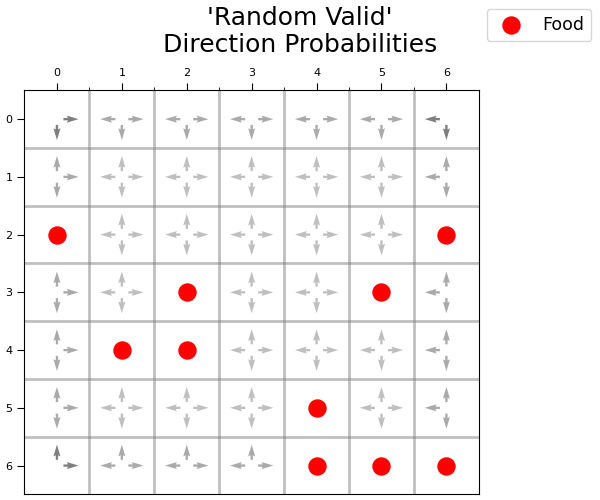

In [2]:
# @markdown Run this cell to see the movement direction probabilities for the 'Random Valid' policy. The darkness of each arrow, *alpha level* in plotting lingo, is proportional to the probility of moving in that direction.
gwg = GridworldGame(batch_size=2, n_cols=7, n_rows=7, num_critters=1)
init_state = gwg.get_init_board()
rvp = RandomValidPlayer(gwg, 1)
gwg.plot_moves(init_state, rvp, title="'Random Valid'\nDirection Probabilities")
plt.show()

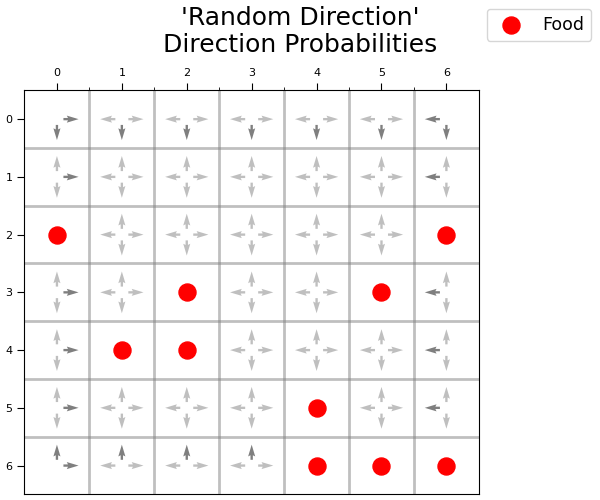

In [3]:
# @markdown Run this cell to see the effective movement probabilities of the 'Random Direction' policy.
rdp = RandomDirectionPlayer(gwg)
gwg.plot_moves(init_state, rdp, title="'Random Direction'\nDirection Probabilities")
plt.show()

**Question:** Although the 'Random Valid' and 'Random Direction' policies are very similar, there are some slight differences. Can you pinpoint these differences and the specific contexts in which they occur?
[Answer](## "Along the board's edges, the 'Random Direction' policy moves away from the edge with probability 1/2. In contrast, the 'Random Valid' policy moves away from the edge with a probability of 1/3.")

Next let's compare the heavily optimized and omniscient GW7x7-10-30 policy (a combination of Deep Reinforcement Learning and Monte Carlo search), with the 'Parameterized Weights' policy (linear weights from a limited perceptual field determine the probability of movement direction.)

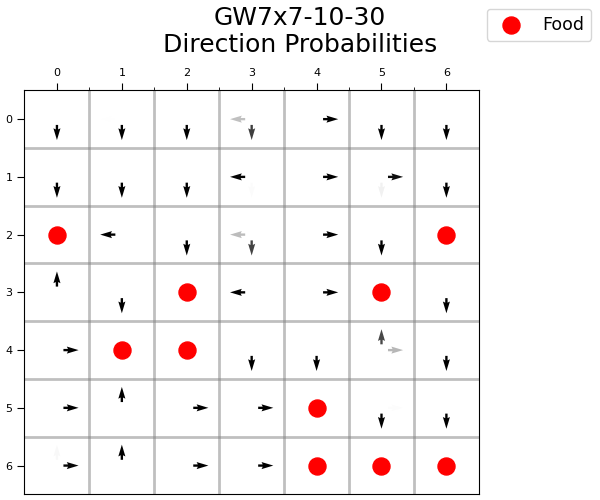

In [4]:
# @markdown Run this cell to see the direction probabilities for GW7x7-10-30's.

pvnetMC = PolicyValueNetwork(gwg)
mcp = MonteCarloBasedPlayer(gwg, pvnetMC, default_depth=3,
                            default_rollouts=80, default_temp=0.02)


#grab the saved model from the repo or where it ends up being hosted
url = "https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C1_BehaviourAsPolicy/data/pvnetMC.pth.tar"
r = requests.get(url)

if r.status_code == 200:
  filename = os.path.basename(url)
  # Write the contents to a file in the current working directory
  with open(filename, 'wb') as file:
    file.write(r.content)
    #print(f'{filename} downloaded successfully.')
else:
  print('Error occurred while downloading the file.')

# load the saved model
pvnetMC.load_checkpoint(folder=os.getcwd(), filename='pvnetMC.pth.tar')

gwg.plot_moves(init_state, mcp, title="GW7x7-10-30\nDirection Probabilities")
plt.show()

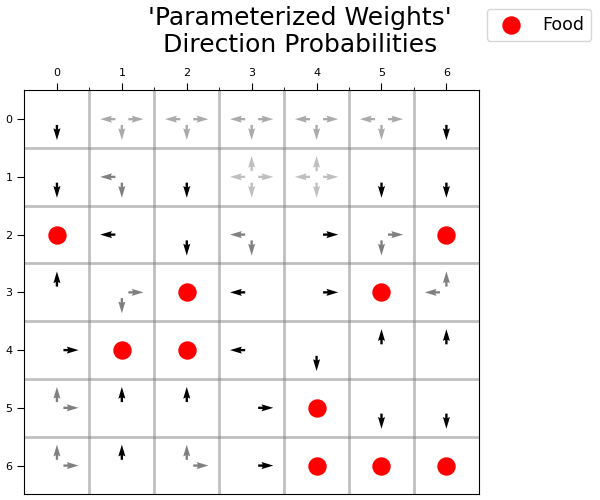

In [5]:
# @markdown Run this cell to see the direction probabilities of the 'Parameterized Weights' policy.

ppp = PerceptParamPlayer(gwg)
gwg.plot_moves(init_state, ppp, title="'Parameterized Weights'\nDirection Probabilities")
plt.show()

It looks like the 'Parameterized Weights' policy and GW7x7-10-30 are somewhat similar. Instead of having to scroll back and forth to compare these policies we can plot the two policies side by side on the same board and see where they are the same, and where they differ.

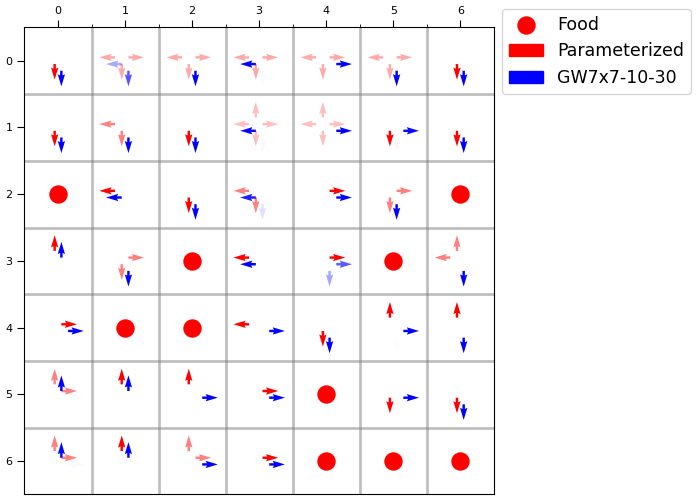

In [6]:
# @markdown Run this cell to compare 'Parameterized Weights' and 'GW7x7-10-30' side by side.
gwg.plot_moves(init_state, player0=ppp, g=0, player1=mcp, p0_name='Parameterized', p1_name='GW7x7-10-30', figsize=(7,5))
plt.show()

Now let's compare these two policies.
Questions:
1.   Looking at grid cells (5,3) and (4,4), the two policies are very similar. Why might this be?
2.   Looking at grid cell (1,3) the policies differ, how and why?
3. Looking at grid cells (4,3) and (4,5) the policies differ again but for different reasons. What are these differences and their reasons?

[Answer](## "In some cells, like (5,3) and (4,4) the two policies behave identically, efficiently moving to nearby food. In cases like this the parameterized policy acts on nearby relevant info in the same way as the more complicated policy. In other cells like (1,3) the two polices are very different and this can be chalked up to the fact that the parameterized policy has limited perception and so cannot navigate efficiently to distant food. In this cell (1,3) its perceptual field is empty, in contrast GW7x7-10-30 'sees' the whole board and so knows how to move towards distant food. However, in yet other cells, like (4,5), more interesting differences appear. The parameterized policy is inherently a short term maximizer, and so it moves immediately towards the food at (6,5). In contrast GW7x7-10-30 has learned to sometimes forgo immediate reward to 'set itself up' for an efficient series of moves, and so moves to (5,6) after which it will be able to make (at least) four eating moves in a row. (Note that this holds only for the board configuration when random seed set as SEED = 2021).")

While there are sets of parameters that will allow the parameterized player to behave like GW7x7-10-30 in some circumstances, the basic architecture of the 'Parameterized Weights' policy is not sufficiently rich to match GW7x7-10-30 in all circumstances.

The 'Parameterized Weights' policy chooses a direction based on a linear combination of its perceptual inputs. This enables it to move towards the centers of high-density patches of food. In contrast, the non-linear architecture of GW7x7-10-30 allows it to both move towards the edges of high-density patches of food *and then* move efficiently through the patch, effectively implementing a more subtle logic that takes into account future moves.

In [7]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.1.3.2: Memory

Up to this point, all the policies we've examined have based their actions on immediate perceptions of the environment. However, in many cases taking into account what has happened in the past can drastically improve the efficiency of a policy. While GW7x7x-10-30's omniscience negates the potential benefits of integrating memory into its decision-making, other policies, particularly the simple 'Random Valid' policy, can benefit from even very simple incorporation of memory.

To see this, we will now make a modified version of the random player that remembers which grid cell it was in last round and uses this to avoid immediate backtracking. It is worth noting that "memory", especially in straightforward cases like this, need not be solely dependent on an internal neural state. Instead, memory might also be fully or partially embedded in an organism's movement mechanics. For instance, "memory" could be an orientation in relation to the direction of motion, with new decisions based on this relative orientation. Regardless of the mechanism, some ability to integrate the past can be beneficial.

Let's implement this 'Memory Improved Random Valid' policy.

In [8]:
# @markdown Run this cell to define the tests for the coding exercise below.

import numpy as np

def test_memory_reset(game):
  player = RandomValidMemoryPlayer(game)
  board = game.get_init_board()
  board['rounds_left'] = np.zeros(board['rounds_left'].shape)
  player.last_locs = [0]
  player.play(board)
  assert player.last_locs is None, "Memory was not reset after the last round!"
  return "Memory reset test passed!"

def test_memory_update(game):
  player = RandomValidMemoryPlayer(game)
  board = game.get_init_board()
  expected_last_loc = game.moves_to_actions(np.where(board['pieces'] == player.critter_index))
  player.play(board)
  assert np.array_equal(player.last_locs, expected_last_loc), "Memory was not updated correctly!"
  return "Memory update test passed!"

def test_invalidating_old_moves(game):
  player = RandomValidMemoryPlayer(game)
  # Define an initial board state
  board = {
  'pieces': np.zeros((1, 7, 7)),
  'scores': np.array([0]),
  'rounds_left': np.array([2]),
  'active_player': 0
  }
  # Set a starting position for the player (for example, center of the board)
  board['pieces'][0, 3, 3] = 1
  #play the board
  _, _, probs = player.play(board)
  # Manually set this starting position to last_locs
  player.last_locs = [3 * 7 + 3]  # This translates (3,3) to a flattened index
  # Ensure the player doesn't move back to the previous position
  assert probs[0][player.last_locs[0]] == 0, "Backtracking was not invalidated!"
  return "Invalidating old moves test passed!"

def test_probabilities(game):
    player = RandomValidMemoryPlayer(game)
    board = game.get_init_board()
    _, _, probs = player.play(board)
    assert np.isclose(np.sum(probs), 1), "Probabilities don't sum up to 1!"
    return "Probabilities test passed!"

def test_valid_actions(game):
    player = RandomValidMemoryPlayer(game, critter_index=1)
    board = game.get_init_board()
    actions, _, _ = player.play(board)
    valids = game.get_valid_actions(board, player.critter_index)
    for action in actions:
        assert valids[0][action] == 1, f"Invalid action: {action}"
    return "Valid actions test passed!"

def run_all_tests():
    test_game = GridworldGame(batch_size=2,
                              n_rows=7, n_cols=7, num_critters=1,
                              num_food=10, lifetime=30)
    tests = [test_memory_reset, test_memory_update, test_invalidating_old_moves,
             test_probabilities, test_valid_actions]
    for test_func in tests:
        result = test_func(test_game)
        print(result)


def run_all_tests():
  test_game = GridworldGame(batch_size=1, n_rows=7, n_cols=7, num_critters=1,
                            num_food=10, lifetime=30)
  tests = [test_memory_reset, test_memory_update, test_invalidating_old_moves,
           test_probabilities, test_valid_actions]
  for test_func in tests:
    result = test_func(test_game)
    print(result)

In [9]:
################################################################################
# TODO for students: Complete the lines with ...  to stop the critter from
# moving to cells it was in immediately before, and to update the memory of
# where the critter was last round. Then comment out the line below and see if
# your code runs and passes the code checks.
raise NotImplementedError("Exercise: limit backtracking with memory")
################################################################################

class RandomValidMemoryPlayer():
  """
  Instantiate random player that uses memory for GridWorld
  """


  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.last_locs = None


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index)
    #invalidate old moves using memory of where critter last was
    if self.last_locs is not None:
      valids[(np.arange(batch_size), self.last_locs)] = ...
    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)
    action_size = n_rows * n_cols
    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    # update memory
    rounds_left = board['rounds_left'][0]
    if rounds_left > 1:
      self.last_locs = self.game.moves_to_actions(
          np.where(board['pieces'] == ... ))
    else:
      # last move of the game reset memory for next game
      self.last_locs = None
    return np.array(a), a_1hots, probs

run_all_tests()

NotImplementedError: ignored

In [10]:
# to_remove solution

class RandomValidMemoryPlayer():
  """
  Instantiate random player that uses memory for GridWorld
  """


  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.last_locs = None


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index)
    #invalidate old moves using memory of where critter last was
    if self.last_locs is not None:
      valids[(np.arange(batch_size), self.last_locs)] = 0
    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)
    action_size = n_rows * n_cols
    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    # update memory
    rounds_left = board['rounds_left'][0]
    if rounds_left > 1:
      self.last_locs = self.game.moves_to_actions(
          np.where(board['pieces'] == self.critter_index ))
    else:
      # last move of the game reset memory for next game
      self.last_locs = None
    return np.array(a), a_1hots, probs

run_all_tests()

Memory reset test passed!
Memory update test passed!
Invalidating old moves test passed!
Probabilities test passed!
Valid actions test passed!


In [11]:
# To figure out this exercise you might want/need to play around with and think
# about what self.last_locs should look like, and what valids does look like.
# To do that run this cell and then hack around a bit.
gwg_explore = GridworldGame(batch_size=1, n_rows=7, n_cols=7, num_critters=1,
                            num_food=10, lifetime=30,
                            rng=np.random.default_rng(seed=5))
init_board = gwg_explore.get_init_board()
print('Initial board state')
print(init_board)
valids = gwg_explore.get_valid_actions(init_board, critter=1)

print('\n-----------------------------------------------------')
print('Human friendly (text) display of the board:')
gwg_explore.display(init_board, g=0)

print('\n-----------------------------------------------------')
print('np.where critter location format:')
display(np.where(init_board['pieces']==1))


print('\n-----------------------------------------------------')
print('Flattened index representation of critter location')
display(gwg_explore.moves_to_actions(
          np.where(init_board['pieces']==1)))


print('\n-----------------------------------------------------')
print('Human friendly (text) display of the valid moves')
gwg_explore.display_moves(init_board, g=0)

print('\n-----------------------------------------------------')
print('Array representation of Valids')
print('Shape of valids:' +str(valids.shape))
print(valids)

Initial board state
{'pieces': array([[[-1.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0., -1.,  0.,  0.,  0., -1.,  0.],
        [-1.,  0.,  0.,  0., -1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0., -1.]]]), 'scores': array([[0.]]), 'rounds_left': array([30.]), 'active_player': 0}

-----------------------------------------------------
Human friendly (text) display of the board:
   0 1 2 3 4 5 6 
-----------------------
0 |X - X - - - - |
1 |- - - - - - 0 |
2 |- - - - - - X |
3 |- X - - - X - |
4 |X - - - X X - |
5 |- - - - - - - |
6 |- - - - X - X |
-----------------------
Rounds Left: 30.0
Score: [0.]

-----------------------------------------------------
np.where critter location format:


(array([0]), array([1]), array([6]))


-----------------------------------------------------
Flattened index representation of critter location


array([13])


-----------------------------------------------------
Human friendly (text) display of the valid moves
  
possible moves
   0 1 2 3 4 5 6 
-----------------------
0 |- - - - - - 0 |
1 |- - - - - 0 - |
2 |- - - - - - 0 |
3 |- - - - - - - |
4 |- - - - - - - |
5 |- - - - - - - |
6 |- - - - - - - |
-----------------------

-----------------------------------------------------
Array representation of Valids
Shape of valids:(1, 49)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


Why does `pieces` represent the board as a batch of 7x7 arrays, but `valids` give a boolean (or mask-based) index for a flattened 7x7 array? How does the boolean index provided by `valids` relate to directions relative to the organism's location? Why is the organism's location represented both as a triple of arrays by the output of `np.where` but also as a flattened index of the 7x7 array?

The reason for this diversity of representations of the same fundamental underlying state is that different types of computation and reasoning are much more efficient using different representations. This efficiency can and often does compensate for the additional effort of maintaining and translating between a variety of representations. (The transformation of inputs into internal representations well suited to specific computations is a critical aspect of neural processing that we will explore later in this book.)

Up to this point, we've abstracted many details of data representation to streamline the material. While this approach generally simplifies the learning process, it is also essential to be aware of these behind-the-scenes complexities. Wholly ignoring these details would do you a disservice, especially given that the often tedious bookkeeping involved in translating between data representations is integral to the implementation of effective learning algorithms.

Now that we've got our memory-enhanced random drifter, let's see how it compares to memoryless random drifting.

In [12]:
# @title Random Drifting with and without memory
# @markdown **Run the cell** and press start to compare the random + memory policy we defined above with memoryless random drifting.

class RandomValidMemoryPlayer():
  """
  Instantiate random player that uses memory for GridWorld
  """


  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.last_locs = None


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index)
    #invalidate old moves using memory of where critter last was
    if self.last_locs is not None:
      valids[(np.arange(batch_size), self.last_locs)] = 0
    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)
    action_size = n_rows * n_cols
    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    # update memory
    rounds_left = board['rounds_left'][0]
    if rounds_left > 1:
      self.last_locs = self.game.moves_to_actions(
          np.where(board['pieces']==self.critter_index))
    else:
      # last move of the game reset memory for next game
      self.last_locs = None
    return np.array(a), a_1hots, probs


gwg = GridworldGame(batch_size=2,
                    n_rows=7, n_cols=7,
                    num_critters=1,
                    num_food=10,
                    lifetime=30,
                    rng=np.random.default_rng(seed=9))
rvp = RandomValidPlayer(gwg)
rvmp = RandomValidMemoryPlayer(gwg)
h2h_igwg = Head2HeadGridworld(gwg, player0=rvp, p0_short_name='RANDOM',
                              p0_long_name='Random Valid\nPolicy',
                              player1=rvmp, p1_short_name='MEMORY',
                              p1_long_name='Random + Memory\nPolicy',
                              figsize=(2.4,3.0), has_fov=False, radius=2,
                              critter_name='$\mathit{Critter}$')
display(h2h_igwg.b_fig0.canvas)
display(h2h_igwg.b_fig1.canvas)
display(h2h_igwg.b_fig_legend.canvas)
clear_output()
display(h2h_igwg.final_display)

How much more efficient was drifting with memory? Why? Determining exactly how much more efficient the elimination of backtracking makes random drifting is challenging. However, we can reason through a rough upper bound on the improvement as follows:

1. The gains in efficiency largely come from the avoidance of backtracking.
2. A random mover spends on average more than 1/4 of its time backtracking. To figure out precisely how much backtracking occurs, we'd need to know the amount of time spent in corners and on the edges, where the probability of backtracking is greater relative to the middle. However, more than 1/4 is a good enough estimate for now.
3. Assume that when not backtracking, the 'Random Valid' and 'Random Valid + Memory' policies are equally likely to consume food. This assumption probably isn't exactly true, but it's close enough for a rough answer.
4. If the 'Random Valid' policy is throwing away at least 1/4 of moves due to direct backtracking, then the average score of 'Random Valid + Memory' should be at least 1.33 times greater.

Run the above simulation a few more times, until the average scores appear to have stabilized. How much better is 'Random Valid + Memory' compared to 'Random Valid'? Is the improvement more, less, or about 1.33 times better?


Reasoning exercises like this can serve as both a sanity check of intuitions against data and of data (including collection and display) against intuitions.

In [13]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.1.3.3 Interacting Policies
So far, when we have compared policies, each organism has been contentedly pursuing its objectives in its own personal private Gridworld universe, and we have assessed the efficiency of each organism acting in isolation. However, for many organisms, a key aspect of life is competition—specifically, competition for limited resources critical to survival and replication, such as food, viable nesting sites, and mating opportunities. Competition can occur between conspecifics or organisms of different species. For example, individuals of a prey species may compete among themselves to avoid being eaten by a predator while also competing directly with individuals of the predator species over who gets eaten and who goes hungry.

To explore how competition might affect performance, we now modify Gridworld to include two different organisms that take turns moving (and eating if they land on food, they do not eat each other yet). Food is immediately replenished after being consumed; strictly speaking, it is not more scarce. However, the presence of two organisms pursuing the same goal does create a more complex environment with new dynamics. In this multi-organism Gridworld, organisms are not allowed to move onto a space already occupied by another organism, much like they can't move off the board.

Let's observe what happens when GW7x7-10-30 and the 'Parameterized Weights' policy compete directly in this shared environment. For now, neither policy perceives the other organism. Specifically, each organism perceives the grid cell occupied by the other organism as empty when initially determining action probabilities; that is they employ the same policies as they did in the single-organism version of Gridworld. However, these initial action probabilities are now re-normalized over valid movement options to avoid moving onto the grid cell occupied by the other organism.

In [14]:
# @title 'Parameterized Weights' and GW7x7-10-30 in a Shared Environment
# @markdown Don't worry about how this code works – just **run this cell** and press the start button to see the 'Parameterized Weights' policy and GW7x7-10-30 in a shared environment.
rng = np.random.default_rng(seed=420)
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7,
                    num_critters=2, num_food=10,
                    lifetime=30, rng=rng)
init_board = gwg.get_init_board()
pvnetMC = PolicyValueNetwork(gwg)
#grab the saved model from the repo or where it ends up being hosted
url = "https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C1_BehaviourAsPolicy/data/pvnetMC.pth.tar"
r = requests.get(url)

if r.status_code == 200:
  filename = os.path.basename(url)
  # Write the contents to a file in the current working directory
  with open(filename, 'wb') as file:
    file.write(r.content)
    #print(f'{filename} downloaded successfully.')
else:
  print('Error occurred while downloading the file.')

# load the saved model
pvnetMC.load_checkpoint(folder=os.getcwd(), filename='pvnetMC.pth.tar')

ppp = PerceptParamPlayer(gwg, critter_index=1)
mcp = MonteCarloBasedPlayer(gwg, pvnetMC, critter_index=2, default_depth=4,
                            default_rollouts=120, default_temp=0.01)
compete1_igwg = InteractiveGridworld(gwg, init_board=init_board, figsize=(4,4),
                                     critter_names=['Params', 'GW7x7'],
                                     players=[ppp, mcp])
display(compete1_igwg.b_fig.canvas)
display(compete1_igwg.b_fig_legend.canvas)
clear_output()
display(compete1_igwg.final_display)

Just watching a few simulations it's difficult to pin down whether sharing the environment is a net positive or negative for these policies. Sometimes a shared environment can make the policies more efficient, like when one organism eating food makes new food appear closer to the other organism. In other instances though, the two organisms, being unaware of each other, pursue the same food and end up getting in each other's way, depleting the immediately available food more quickly. Specifically, this version of GW7x7-10-30 does not take into account another organism. So, sometimes when GW7x7-10-30 forgoes immediate reward to 'set up' a series of efficient eating moves, the other organism swoops in, eats the food, and wrecks the plan.

Later, we will examine such mechanisms statistically. For now, let's see if you can use these insights when playing with or against the 'Parameterized Weights' policy (solo version) in a shared environment. First, try to maximize your score without worrying about what the other organism's score is. Then, try to maximize the difference between your score and the other organism without worrying about how high your score is over all. Lastly, try to maximize the other organism's score.

In [15]:
# @title You and the 'Parameterized Weights' Policy in a Shared Environment
# @markdown Don't worry about how this code works – just **run this cell** and then press a direction button to play with (against?) the 'Parameterized Weights' policy.
rng = np.random.default_rng(seed=420)
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7,
                    num_critters=2, num_food=10,
                    lifetime=30, rng=rng)
init_board = gwg.get_init_board()
ppp = PerceptParamPlayer(gwg, critter_index=2)
compete2_igwg = InteractiveGridworld(gwg, init_board=init_board, figsize=(4,4),
                                     critter_names=['You', 'Params'],
                                     players=['human', ppp])
display(compete2_igwg.b_fig.canvas)
display(compete2_igwg.b_fig_legend.canvas)
clear_output()
display(compete2_igwg.final_display)

How did you do? How did you adjust your strategy depending on what your goal was?

This concludes the sequence on abstraction and reasoning about policies. By thinking of policies as functions that turn environmental inputs into behavioural outputs, we directly compared policies to see in which contexts they were the same and in which contexts they differed. As another form of more direct comparison, we looked at two organisms sharing, and to some extent competing, in the same environment. We saw that policies that had worked well in isolation did not always work quite so well in this new shared environment; a good policy for one environment might not be so great in another. The environment isn't just a static thing, but potentially a rich dynamical system dependent on the variety of organisms that live there. So, this grand challenge of biology and evolution—setting up policies that work in the real world—is even trickier than it might seem at first.

In [16]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# Quiz

In [17]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {"question": "In this sequence, what did we focus on when comparing policies?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "Analyzing the computing power each policy requires.",
       "correct": False,
       "feedback": "False. The focus was not on computational requirements."},
      {"answer": "Examining how each policy behaves in different environmental contexts.",
       "correct": True,
       "feedback": "Correct. The main focus was on behavior in different contexts."},
      {"answer": "Determining which policy is the most efficient forager.",
       "correct": True,
       "feedback": "This was a secondary focus in this sequences."},
      {"answer": "Studying the ability of each policy to adapt over time.",
       "correct": False,
       "feedback": "False. Adaptation over time was not the focus of the comparison."}
    ]
  },
  {"question": "What was the primary reason for introducing memory into policies in this sequence?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "To increase the computational complexity of a policy.",
       "correct": False,
       "feedback": "False. The aim was not to make the policy more complex."},
      {"answer": "To decrease the computational complexity of a policy.",
       "correct": False,
       "feedback": "False. Simplification was not the primary goal."},
      {"answer": "To demonstrate the potential performance benefits of memory.",
       "correct": True,
       "feedback": "Correct. The primary reason was to show how memory could improve performance."},
      {"answer": "To make movement more random by eliminating backtracking.",
       "correct": False,
       "feedback": "False. The aim was not to randomize movements."}
    ]
  },
  {"question": "What is the purpose of having different types of representations for different aspects of the same underlying state like 'pieces' and 'valids'?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "To confuse the reader.",
       "correct": False,
       "feedback": "False. Confusion is not the intent."},
      {"answer": "To enable efficient computation and reasoning.",
       "correct": True,
       "feedback": "Correct. Different representations facilitate different types of computation."},
      {"answer": "To make the source code easier to read.",
       "correct": False,
       "feedback": "False. Readability is important and related but not the primary reason."},
      {"answer": "To increase the time it takes for the agent to make a decision.",
       "correct": False,
       "feedback": "False. Increasing decision time is not the goal."}
    ]
  },
  {"question": "How does sharing an environment with another organism generally affect the foraging efficiency of policies?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "Efficiency is reduced due to competition for scarce resources.",
       "correct": True,
       "feedback": "Competition can reduce foraging efficiency, but there is a more complete answer."},
      {"answer": "Efficiency is improved because the consumption of food by one organism generates new food in locations that might be more accessible to the other organism.",
       "correct": True,
       "feedback": "In some cases yes, sharing can lead to synergistic benefits, but there is a more complete answer"},
      {"answer": "Efficiency can vary; it may improve due to synergistic food sharing dynamics or decrease due to competitive obstruction between organisms.",
       "correct": True,
       "feedback": "Correct. The effect on efficiency can be variable, depending on many factors."},
      {"answer": "Efficiency is largely unaffected as both policies operate independently and food is instantly replenished.",
       "correct": False,
       "feedback": "False. Independent policies and instant replenishment of food does not ensure that efficiency will be unaffected."}
    ]
  }
]

display_quiz(comprehension_quiz)

<IPython.core.display.Javascript object>